***Spectral Indexes Computation***

In [1]:
#Importing
import os
import sys
sys.path.insert(1,'./src')
import numpy as np
import matplotlib.pyplot as plt
from find_nearest import find_nearest
plt.style.use('bmh')
import rasterio as rio
from img_list import prs_list
import math
from read_funcs import compute_index,savenpastiff
import seaborn as sns
import matplotlib.ticker as ticker
import statsmodels.api as sm
from scipy.stats import shapiro
from sklearn import preprocessing as prp

In [2]:
#Parameter Initialization
path_l2d = "../DATABASE/"
aerial_path="../DATABASE/aerial/"
PRISMA_path="../DATABASE/PRISMA/"
name='Gad161022'
name_img_prs=prs_list[name]
tstart_prs=prs_list[name][0]
tend_prs=prs_list[name][1]
filename='PRS_L2D_STD_'+tstart_prs+'_'+tend_prs+'_0001'
print(tstart_prs)
prisma=False
validation=False
if prisma:
    path=PRISMA_path
    if validation: 
        area="area5"
        AREA="AREA5"
    else:
        area='total_area'
        AREA='AREA5'
else:
    path=aerial_path
    AREA="AREA5"
    area="area5"
save=True
#veg: vegetation index name, set this parameter with one of the following:  CLRE, GNDVI, NBRI, NDREI, NDVI, NRVI and SLAVI. 
veg='NDREI'

20221016102331


(532, 379, 345)


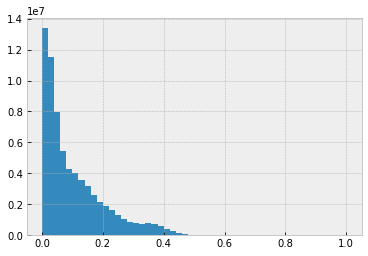

In [3]:
#import reflectance
if prisma:
    if validation:
        src = rio.open(PRISMA_path+'Gad_ref_UTM32N_COREG_'+AREA+'_clip.tif')
    else:
        src = rio.open(PRISMA_path+'Gad_ref_UTM32N_COREG_'+AREA+'.tif')
    reflectance=src.read()
    src.close()
    reflectance=np.moveaxis(reflectance,0,2)    
    wvl=np.load(path_l2d+'/'+name+'_wl.npy')
else:
    src_aerial = rio.open(aerial_path+'Gad_'+area+'_UTM32N.tif')
    raw=src_aerial.read()
    src_aerial.close()
    raw=np.moveaxis(raw,0,2)
    reflectance=raw*0.0001 #scale to reflectance
    reflectance=np.where(reflectance>1,math.nan,reflectance)
    plt.hist(reflectance.ravel(),bins=50)
    wvl=np.load(aerial_path+'aerial_wl.npy')
    print(np.shape(reflectance))

6
0
total: 201628
dead trees pixels: 8691
percentage of trees' pixels: 4%


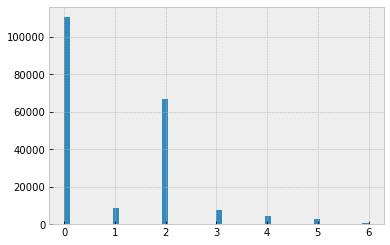

In [4]:
#count percentage of pixels marked as dead trees in validation (to set threshold)
src = rio.open(aerial_path+'Gad_classification_area5_32632.tif')
classification=src.read()
src.close()
classification=np.moveaxis(classification,0,2)
np.shape(classification)
plt.hist(classification.ravel(),bins=50)
print(np.max(classification.ravel()))
print(np.min(classification.ravel()))
total_pixels=np.where(classification!=10,1,0).sum()
print('total: ' + str(total_pixels))
dead_pixels=np.where((classification==1),1,0).sum()
print('dead trees pixels: '+ str(dead_pixels))
percentage=round((dead_pixels*100)/total_pixels)
print("percentage of trees' pixels: "+str(percentage)+'%')

In [5]:
#import aerial trees mask (sieved on qgis) and mask reflectance cube
if prisma:
    if validation:
        trees_mask=np.load(PRISMA_path+'validation/'+area+'/'+name+'_trees_mask_sieved.npy')
    else:
        trees_mask=np.load(PRISMA_path+name+'_trees_mask_sieved.npy')
else:
    trees_mask=np.load(aerial_path+name+area+'_trees_mask_sieved.npy')

trees_mask=np.where(trees_mask==1,trees_mask,np.nan)
trees_ref=np.zeros((np.shape(reflectance)))
for b in range(np.shape(reflectance)[2]):
    trees_ref[:,:,b]=np.multiply(reflectance[:,:,b],trees_mask)

/var/folders/_3/xbqrb2pn61xbq3bc9w9ss3ww0000gn/T/ipykernel_2352/3577459415.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/var/folders/_3/xbqrb2pn61xbq3bc9w9ss3ww0000gn/T/ipykernel_2352/3577459415.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/var/folders/_3/xbqrb2pn61xbq3bc9w9ss3ww0000gn/T/ipykernel_2352/3577459415.py:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


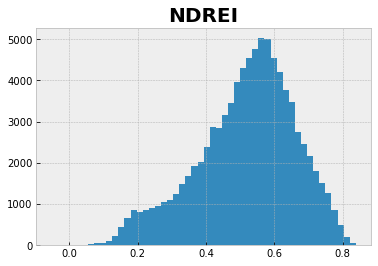

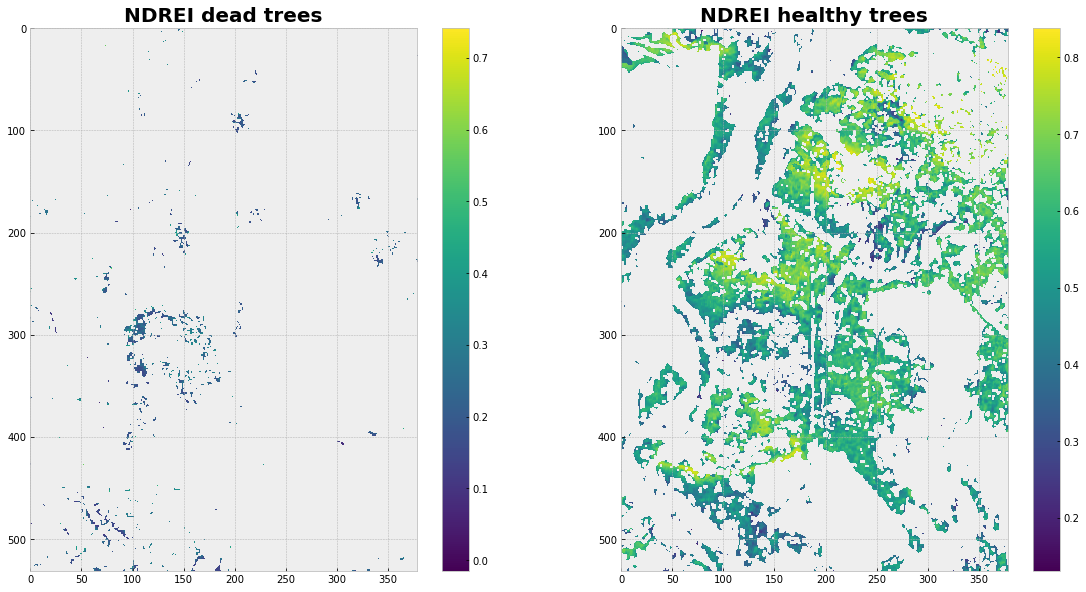

In [6]:
#compute vegetation index
veg_map,veg_threshold=compute_index(trees_ref,veg,wvl)
plt.figure()
plt.hist(veg_map.ravel(),bins=50) 
plt.title(veg,fontweight='bold',fontsize=20)
if prisma:
    plt.figure(figsize=(10,10))
else:
    plt.figure(figsize=(30,10))
plt.imshow(veg_map)
plt.title(veg,fontweight='bold',fontsize=20)
plt.colorbar()
if save:
    if prisma:
        np.save(PRISMA_path+name+'_'+veg,veg_map)
    else:
        np.save(aerial_path+name+'_'+veg,veg_map)
if not prisma:
    dead_trees_mask=np.load(aerial_path+name+'_dead_trees_mask.npy')
    dead=[]
    dead=np.where(dead_trees_mask==1,veg_map,np.nan)
    plt.subplot(1,3,2)
    plt.imshow(dead)
    plt.title(veg+' dead trees',fontweight='bold',fontsize=20)
    plt.colorbar()
    
    healthy_trees_mask=np.load(aerial_path+name+'_healthy_trees_mask.npy')
    healthy=[]
    healthy=np.where(healthy_trees_mask==1,veg_map,np.nan)
    plt.subplot(1,3,3)
    plt.imshow(healthy)
    plt.title(veg+' healthy trees',fontweight='bold',fontsize=20)
    plt.colorbar()

random sample NDREI mean dead trees: 0.2582260749885444
random sample points NDREI std deviation dead trees: 0.09288393860365707


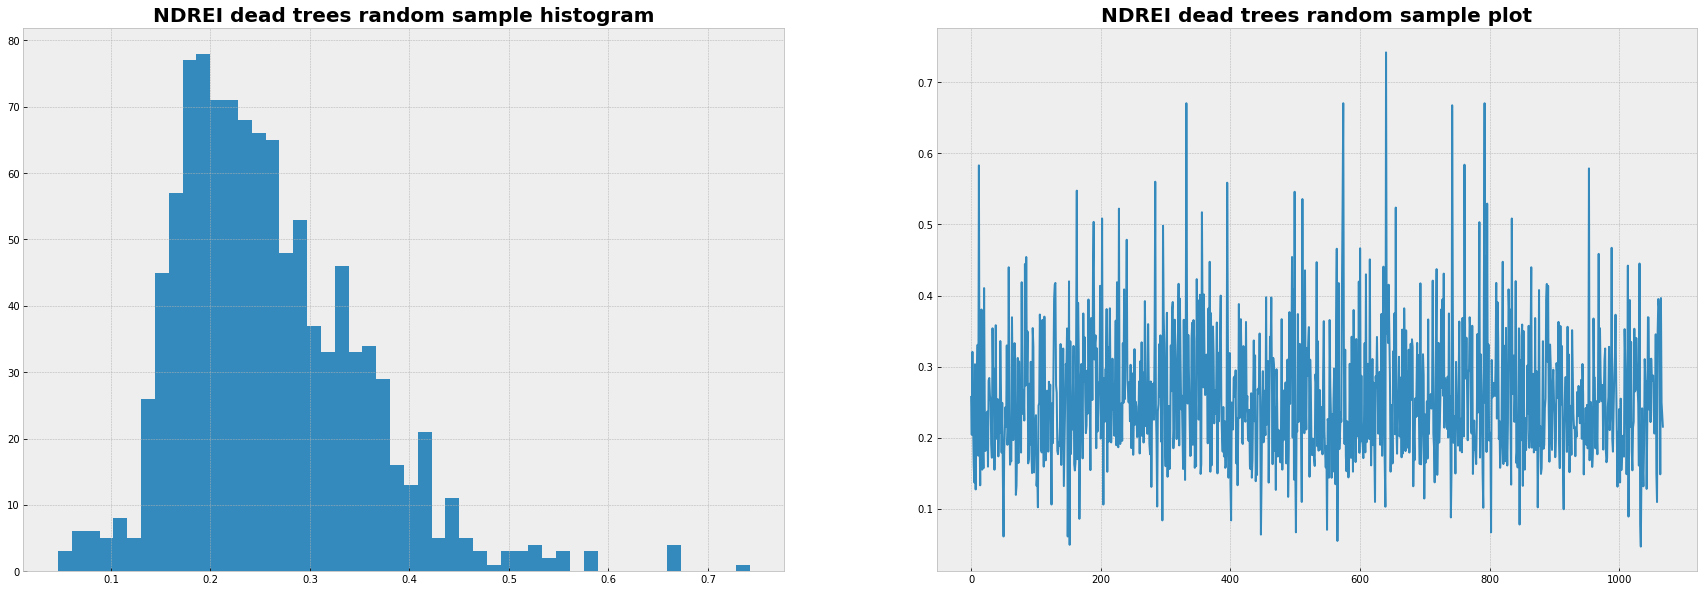

In [7]:
if not prisma: 
    #statistics over random dead trees sample
    index=np.isnan(dead.ravel())
    index=[not item for item in index]
    random_points_dead=np.random.choice(dead.ravel()[index], size=1068)
    plt.figure(figsize=(30,10))
    plt.subplot(1,2,1)
    plt.hist(random_points_dead,bins=50)
    plt.title(veg+' dead trees random sample histogram',fontweight='bold',fontsize=20)
    plt.subplot(1,2,2)
    plt.plot(range(np.shape(random_points_dead)[0]),random_points_dead)
    plt.title(veg+' dead trees random sample plot',fontweight='bold',fontsize=20)
    print('random sample '+veg+' mean dead trees: '+str(np.mean(random_points_dead)))
    print('random sample points '+veg+' std deviation dead trees: '+str(np.std(random_points_dead)))

random sample NDREI mean healthy trees: 0.5527045788527575
random sample points NDREI std deviation healthy trees: 0.1154986154538045


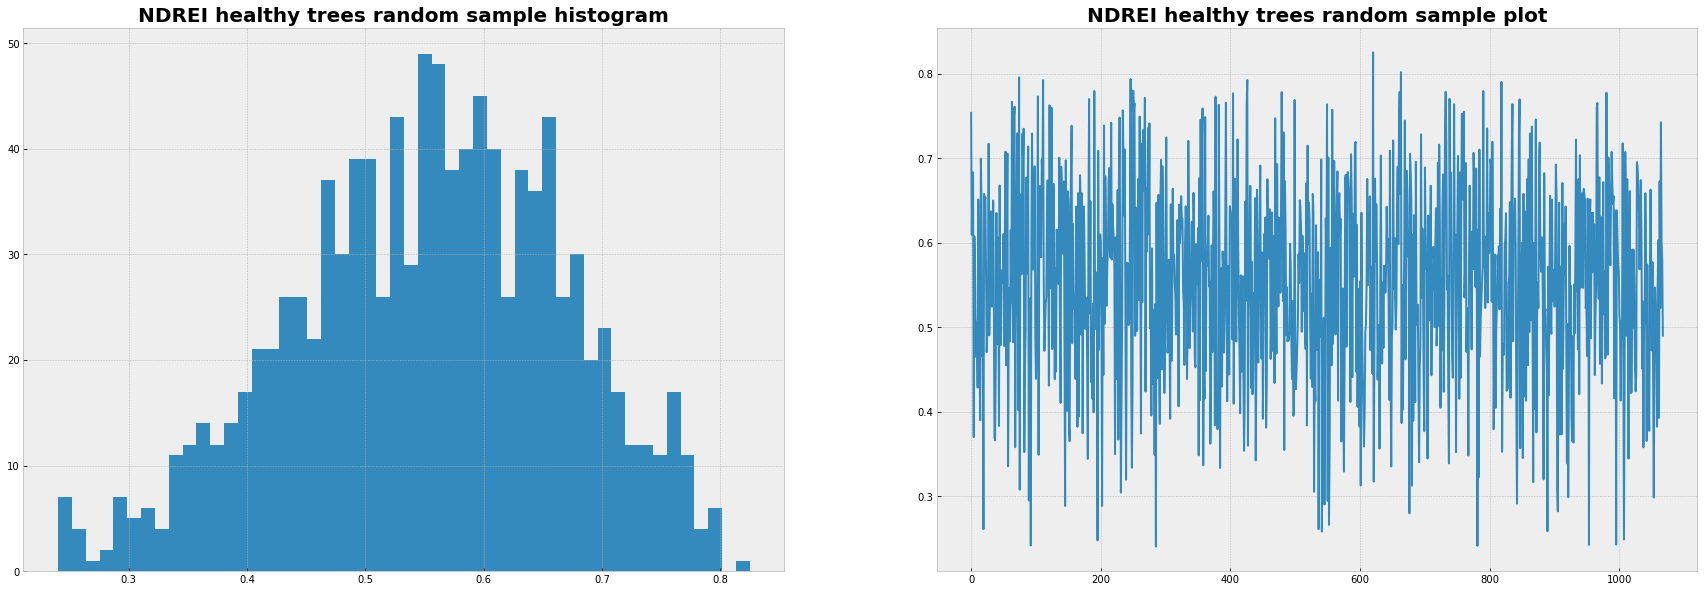

In [8]:
if not prisma: 
    #statistics over random healthy trees sample
    index=np.isnan(healthy.ravel())
    index=[not item for item in index]
    random_points_healthy=np.random.choice(healthy.ravel()[index], size=1068)
    plt.figure(figsize=(30,10))
    plt.subplot(1,2,1)
    plt.hist(random_points_healthy,bins=50)
    plt.title(veg+' healthy trees random sample histogram',fontweight='bold',fontsize=20)
    plt.subplot(1,2,2)
    plt.plot(range(np.shape(random_points_healthy)[0]),random_points_healthy)
    plt.title(veg+' healthy trees random sample plot',fontweight='bold',fontsize=20)
    print('random sample '+veg+' mean healthy trees: '+str(np.mean(random_points_healthy)))
    print('random sample points '+veg+' std deviation healthy trees: '+str(np.std(random_points_healthy)))

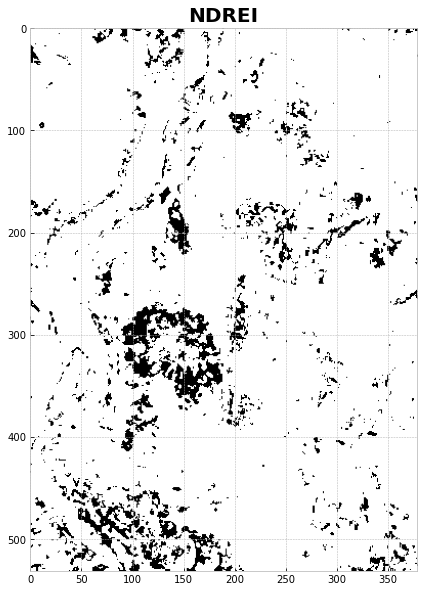

In [9]:
#binary classification
if veg=='CLRE':
    veg_binary=np.where(veg_map>veg_threshold,1,0)
else:
    veg_binary=np.where(veg_map<veg_threshold,1,0)
plt.figure(figsize=(10,10))
plt.title(veg,fontweight='bold',fontsize=20)
plt.imshow(veg_binary,cmap='binary')
np.save(path+'index_bin/'+area+'/'+veg,veg_binary)

In [10]:
print(np.nan>0.4)

False


/var/folders/_3/xbqrb2pn61xbq3bc9w9ss3ww0000gn/T/ipykernel_2352/3686401424.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot=sns.distplot(a,label=lab[idx] , ax=ax, kde=True)
/var/folders/_3/xbqrb2pn61xbq3bc9w9ss3ww0000gn/T/ipykernel_2352/3686401424.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot=sns.distp

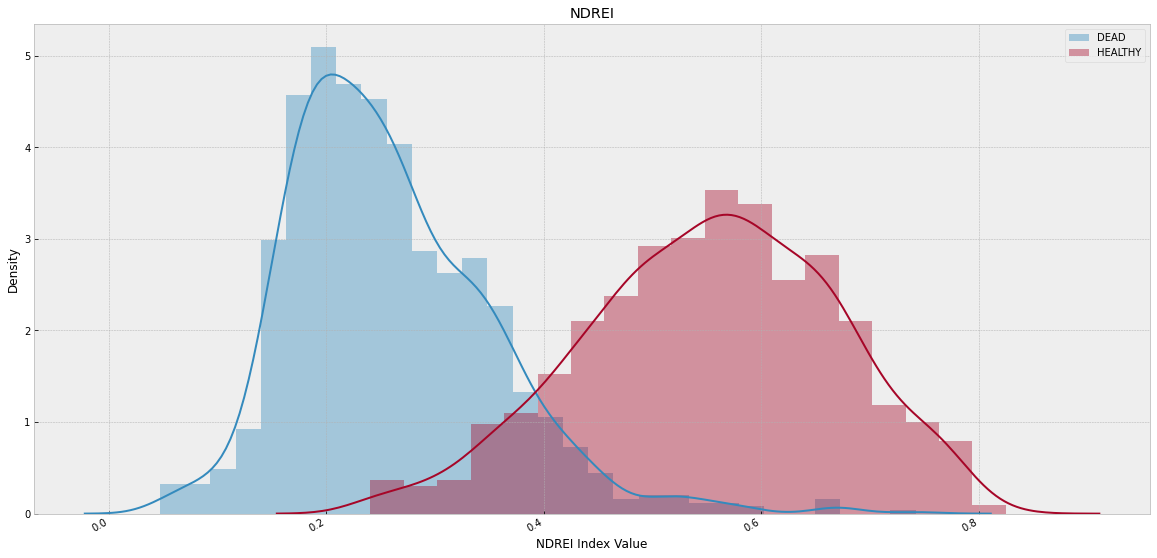

In [11]:
if not prisma: 
    fig, ax = plt.subplots(figsize=(20,10))
    lab=['DEAD','HEALTHY']
    for idx,a in enumerate([random_points_dead, random_points_healthy]):
        plot=sns.distplot(a,label=lab[idx] , ax=ax, kde=True)
    plt.title(veg)
    
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.xlabel(veg+' Index Value')
    plt.legend()
    plot.get_figure().autofmt_xdate()

<Figure size 360x360 with 0 Axes>

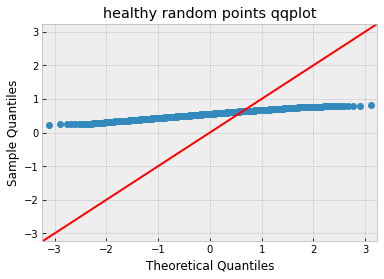

<Figure size 360x360 with 0 Axes>

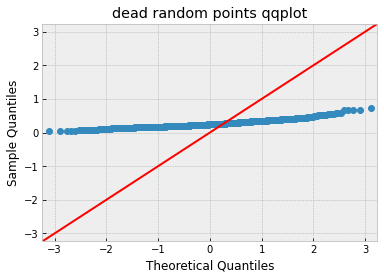

In [12]:
if not prisma: 
    plt.figure(figsize=(5,5))
    fig=sm.qqplot(random_points_healthy, line='45')
    plt.title('healthy random points qqplot')
    plt.show()
    plt.figure(figsize=(5,5))
    fig1=sm.qqplot(random_points_dead, line='45')
    plt.title('dead random points qqplot')
    plt.show()

In [13]:
if not prisma: 
    stat_healthy,p_healthy=shapiro(random_points_healthy)
    stat_dead,p_dead=shapiro(random_points_dead)
    if p_healthy>0.05:
        print('the healthy sample is normally distributed (p-value: '+str(p_healthy)+')')
    else:
        print('the healthy sample is NOT normally distributed (p-value: '+str(p_healthy)+')')
    if p_dead>0.05:
        print('the dead sample is normally distributed (p-value: '+str(p_dead)+')')
    else:
        print('the dead sample is NOT normally distributed (p-value: '+str(p_dead)+')')

the healthy sample is NOT normally distributed (p-value: 1.7045254935510457e-05)
the dead sample is NOT normally distributed (p-value: 1.6212486681976748e-18)
